In [1]:
import numpy as np
import uproot as up
from ipynb.fs.defs.covfit import *
from matplotlib import pyplot as plt
from scipy.stats import chi2, normaltest

In [6]:
# Load the data from https://arxiv.org/abs/1811.02774 and https://arxiv.org/abs/1801.01197

files = {
    "Genie_10a": "MINERvA_CC0pi_GENIEv3.00.06_G18_10a_02_11a.root",
    "Genie_10b": "MINERvA_CC0pi_GENIEv3.00.06_G18_10b_00_000.root",
    "Neut": "MINERvA_CC0pi_NEUTv5.4.1.root",
    "NuWro": "MINERvA_CC0pi_NUWROv19.02.2.root",
    "SuSAv2": "SuSAv2MnvComp.root",
}

modes = ["nu", "antinu"]

data = {}
shape = {}
MC = {}
MC_shape = {}
MC_scale = {}
var = {}
shape_var = {}
total_error = {}
cov = {}
cov_inv = {}
bin_widths = {}
data_integral = {}
MC_integral = {}
shape_total_cov = {}
shape_total_cov_inv = {}
shape_cov = {}
shape_cov_inv = {}

for gen, filename in files.items():
    with up.open(filename) as F:
        for mode in modes:
            # Covariance and variance of data
            cov[mode] = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_COV"]
            cov[mode] = cov[mode].to_numpy()[0]
            var[mode] = np.diag(cov[mode])

            # Remove empty bins
            i_good = var[mode] > 0
            print(np.sum(i_good), len(i_good))
            cov[mode] = cov[mode][i_good][:, i_good]

            # Remove unreported bins from antinu cov
            if mode == "antinu":
                cov[mode] = np.delete(cov[mode], [50, 51], axis=0)
                cov[mode] = np.delete(cov[mode], [50, 51], axis=1)

            # Scale covariance in antinu mode
            if mode == "antinu":
                cov[mode] *= 1e-76

            # Get fixed variances
            var[mode] = np.diag(cov[mode])

            # Get bin areas
            dump, xbins, ybins = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_data"].to_numpy()
            xbins = xbins[1:] - xbins[:-1]
            ybins = ybins[1:] - ybins[:-1]
            bin_widths[mode] = xbins[np.newaxis, :] * ybins[:, np.newaxis]
            bin_widths[mode] = bin_widths[mode].flatten()[i_good]
            # bin_widths[mode][:] = 1.0 # Ignore bin widths

            # Remove unreported bins
            if mode == "antinu":
                bin_widths[mode] = np.delete(bin_widths[mode], [50, 51], axis=0)

            # Covariance inverse
            cov_inv[mode] = np.linalg.inv(cov[mode])

            # The data
            hist = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_data_1D"]
            data[mode] = hist.to_numpy()[0][i_good]

            # Remove unreported bins from antinu data
            # For some reason the bins are at the end of the array
            if mode == "antinu":
                data[mode] = data[mode][:-2]

            data_integral[mode] = np.sum(data[mode] * bin_widths[mode])

            # Split shape and norm like in MiniBooNE
            remove_bin = False
            # shape = data[mode] / data_integral[mode]
            jac = np.eye(len(data[mode])) / data_integral[mode] - (
                data[mode][:, np.newaxis]
                * bin_widths[mode][np.newaxis, :]
                / (data_integral[mode] ** 2)
            )
            # Add total xsec bin
            jac = np.append(jac, [bin_widths[mode]], axis=0)
            print(jac.shape)
            Q = jac @ cov[mode] @ jac.T
            Q[:-1, :] *= data_integral[mode]  # Scale shape errors to data result
            Q[:, :-1] *= data_integral[mode]  # Scale shape errors to data result
            # Ignore first bin, perfectly determined by integral
            if remove_bin:
                Q = Q[1:, :][:, 1:]
            shape_var[mode] = np.diag(Q)[:-1]
            total_error[mode] = np.sqrt(Q[-1, -1])
            print(total_error[mode] / data_integral[mode])
            shape_total_cov[mode] = Q
            shape_cov[mode] = Q[:-1, :][:, :-1]
            shape_total_cov_inv[mode] = np.linalg.pinv(Q)
            shape_cov_inv[mode] = np.linalg.pinv(Q[:-1, :][:, :-1])

            # Shape only
            shape[mode] = data[mode]
            # Ignore first bin, determined by total integral
            if remove_bin:
                shape[mode] = shape[mode][1:]

            # Model predictions
            # SuSA needs some extra love
            if gen == "SuSAv2" and mode == "antinu":
                # Get C and H predictions of reported bins
                with up.open(filename[:-5] + "_anuCOnly.root") as G:
                    hist = G[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_MC_1D"].to_numpy()[0]
                with up.open(filename[:-5] + "_anuHOnly.root") as G:
                    hist += G[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_MC_1D"].to_numpy()[0]
            else:
                hist = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_MC_1D"]
                hist = hist.to_numpy()[0][i_good]
                # Remove unreported bins from antinu data
                # For some reason the bins are at the end of the array
                if mode == "antinu":
                    hist = hist[:-2]
            MC[(mode, gen)] = hist
            MC_integral[(mode, gen)] = np.sum(MC[(mode, gen)] * bin_widths[mode])
            MC_scale[(mode, gen)] = data_integral[mode] / MC_integral[(mode, gen)]
            MC_shape[(mode, gen)] = MC[mode, gen] * MC_scale[mode, gen]
            if remove_bin:
                MC_shape[mode, gen] = MC_shape[1:]

            print(data_integral[mode], MC_integral[(mode, gen)])

144 156
(145, 144)
0.0830234290206586
4.635665394345005e-39 4.125221139414906e-39
60 60
(59, 58)
0.09079587065673944
5.543120000000001e-39 4.126393524760919e-39
144 156
(145, 144)
0.0830234290206586
4.635665394345005e-39 4.278429913742801e-39
60 60
(59, 58)
0.09079587065673944
5.543120000000001e-39 4.2739428166014235e-39
144 156
(145, 144)
0.0830234290206586
4.635665394345005e-39 4.23527504918065e-39
60 60
(59, 58)
0.09079587065673944
5.543120000000001e-39 4.2509068908246024e-39
144 156
(145, 144)
0.0830234290206586
4.635665394345005e-39 4.069887886579436e-39
60 60
(59, 58)
0.09079587065673944
5.543120000000001e-39 4.519584614946157e-39
144 156
(145, 144)
0.0830234290206586
4.635665394345005e-39 4.9964757459099394e-39
60 60
(59, 58)
0.09079587065673944
5.543120000000001e-39 4.798743160224612e-39


[[1.         0.61486121 0.02358567]
 [0.61486121 1.         0.01832279]
 [0.02358567 0.01832279 1.        ]]
[[1.         0.43969056 0.22121001]
 [0.43969056 1.         0.19373883]
 [0.22121001 0.19373883 1.        ]]


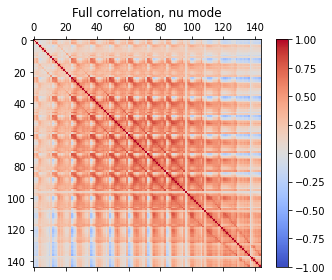

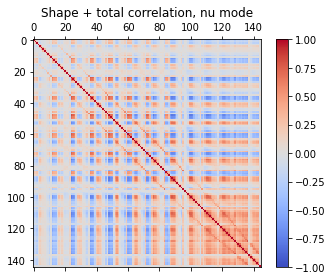

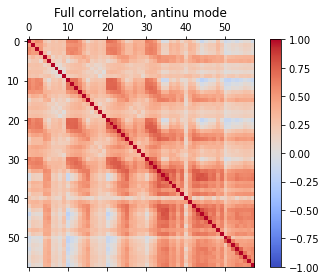

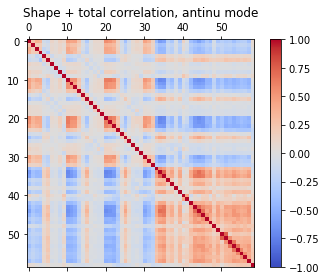

In [7]:
from matplotlib.colors import Normalize

for mode in modes:
    fig, ax = plt.subplots(figsize=(5, 4))
    cor = cov[mode] / (
        np.sqrt(var[mode])[np.newaxis, :] * np.sqrt(var[mode])[:, np.newaxis]
    )
    m = ax.matshow(cor, cmap="coolwarm", norm=Normalize(-1, 1))
    fig.colorbar(m)
    ax.set_title(f"Full correlation, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-corr.pdf")

    fig, ax = plt.subplots(figsize=(5, 4))
    cor = shape_total_cov[mode] / (
        np.sqrt(np.diag(shape_total_cov[mode]))[np.newaxis, :]
        * np.sqrt(np.diag(shape_total_cov[mode]))[:, np.newaxis]
    )
    print(cor[-3:, -3:])
    m = ax.matshow(cor, cmap="coolwarm", norm=Normalize(-1, 1))
    fig.colorbar(m)
    ax.set_title(f"Shape + total correlation, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-corr-decomposed.pdf")

In [8]:
p_all = {}
# as-is p-values
p_all["Original"] = {}
for mode in modes:
    p_mode = {}
    for gen in files:
        p = {}
        # Full covariance p-value
        z = data[mode] - MC[(mode, gen)]
        p["full"] = chi2(df=len(z)).sf(z.T @ cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode])
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_mode[gen] = p
    p_all["Original"][mode] = p_mode

nu Genie_10a
{'full': 8.609362556285357e-41, 'naive': 1.8401451207521963e-47, 'fitted': 0.0, 'invariant': 1.5269041867465804e-20}
nu Genie_10b
{'full': 1.0218289193202951e-43, 'naive': 1.8688373109099157e-41, 'fitted': 0.0, 'invariant': 4.3055896768876105e-21}
nu Neut
{'full': 1.895861093631354e-17, 'naive': 5.061198080856408e-08, 'fitted': 1.7282563097853476e-05, 'invariant': 1.7159722861779135e-05}
nu NuWro
{'full': 7.8233554154225e-22, 'naive': 3.243407589315175e-14, 'fitted': 1.047632203543536e-06, 'invariant': 1.040177505283129e-06}
nu SuSAv2
{'full': 7.869821399187258e-37, 'naive': 4.00166317907757e-18, 'fitted': 1.9510120523591468e-06, 'invariant': 1.937129996425319e-06}
antinu Genie_10a
{'full': 0.008095986537111462, 'naive': 3.771931510986364e-12, 'fitted': 0.024671085480680754, 'invariant': 0.024667660872651532}
antinu Genie_10b
{'full': 0.0148795717311529, 'naive': 3.556910539075126e-09, 'fitted': 0.06730419935312049, 'invariant': 0.06730410855863445}
antinu Neut
{'full': 0.

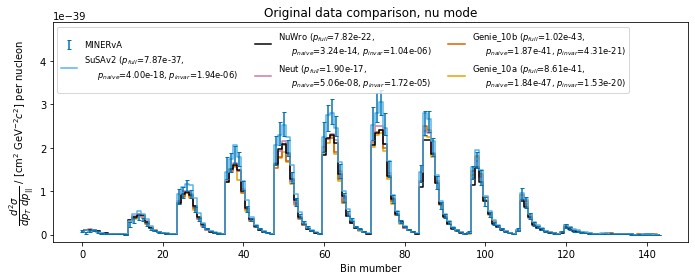

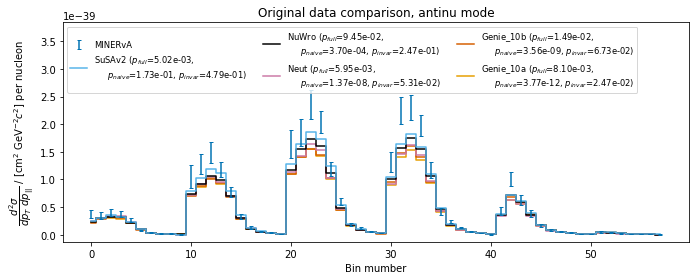

In [9]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.errorbar(
        np.arange(len(data[mode])),
        data[mode],
        np.sqrt(var[mode]),
        linestyle="",
        label="MINERvA",
        zorder=5,
        capsize=2,
    )
    for gen in files:
        ax.step(
            np.arange(len(MC[(mode, gen)])),
            MC[(mode, gen)],
            where="mid",
            label=gen
            + f" ($p_{{full}}$={p_all['Original'][mode][gen]['full']:.2e},\n     "
            + f"$p_{{naive}}$={p_all['Original'][mode][gen]['naive']:.2e}, "
            + f"$p_{{invar}}$={p_all['Original'][mode][gen]['invariant']:.2e})",
        )
    # ax.set_yscale("log")
    ax.set_ylim(top=ax.get_ylim()[1] * 1.4)
    ax.set_xlabel("Bin mumber")
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dp_{T}\ dp_{||}}$ / [cm$^2$ GeV$^{-2} c^{2}$] per nucleon"
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc="upper left",
        ncol=3,
        fontsize="small",
    )
    ax.set_title(f"Original data comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}.pdf")

In [10]:
# shape only p-values
p_all["Shape only"] = {}
for mode in modes:
    p_all["Shape only"][mode] = {}
    for gen in files:
        p = {}
        # Full covariance p-value
        z = shape[mode] - MC_shape[(mode, gen)]
        p["full"] = chi2(df=len(z)).sf(z.T @ shape_cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt((shape[mode] - MC_shape[(mode, gen)]) ** 2)
        z /= np.sqrt(shape_var[mode])
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_all["Shape only"][mode][gen] = p

nu Genie_10a
{'full': 9.366590990139588e-62, 'naive': 8.78205095212922e-84, 'fitted': 0.0, 'invariant': 4.409970618716288e-28}
nu Genie_10b
{'full': 4.320762977714517e-58, 'naive': 1.429628820789235e-78, 'fitted': 0.0, 'invariant': 1.0809083879359728e-26}
nu Neut
{'full': 3.1143240414919516e-26, 'naive': 6.602459873706214e-21, 'fitted': 1.4442845885920264e-07, 'invariant': 1.4340068324543493e-07}
nu NuWro
{'full': 1.9572110192847625e-37, 'naive': 1.6275060850528207e-32, 'fitted': 3.292086603323696e-10, 'invariant': 3.2686065811847853e-10}
nu SuSAv2
{'full': 7.36314991307019e-27, 'naive': 2.5375290827398498e-23, 'fitted': 2.61490679688281e-05, 'invariant': 2.596332110385741e-05}
antinu Genie_10a
{'full': 6.036192711096001e-08, 'naive': 3.0998465959058087e-06, 'fitted': 0.0002645951675210867, 'invariant': 0.00026387678690498244}
antinu Genie_10b
{'full': 2.7130485691382337e-06, 'naive': 2.1928661132366026e-06, 'fitted': 0.04144524745395484, 'invariant': 0.04144194740421621}
antinu Neut
{

In [11]:
# shape + norm only p-values
p_all["Shape & norm."] = {}
for mode in modes:
    p_all["Shape & norm."][mode] = {}
    for gen in files:
        p = {}
        # Full covariance p-value
        z = shape[mode] - MC_shape[(mode, gen)]
        z = np.append(
            z,
            data_integral[mode] - MC_integral[(mode, gen)],
        )
        p["full"] = chi2(df=len(z)).sf(z.T @ shape_total_cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt((shape[mode] - MC_shape[(mode, gen)]) ** 2 / shape_var[mode])
        z = np.append(
            z,
            np.abs(data_integral[mode] - MC_integral[(mode, gen)]) / total_error[mode],
        )

        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_all["Shape & norm."][mode][gen] = p

nu Genie_10a
{'full': 9.657826998249033e-62, 'naive': 9.889188478461526e-84, 'fitted': 0.0, 'invariant': 4.440373914104501e-28}
nu Genie_10b
{'full': 4.989969689442783e-58, 'naive': 2.2792094934906864e-78, 'fitted': 0.0, 'invariant': 1.0883604051594762e-26}
nu Neut
{'full': 3.8664844319407706e-26, 'naive': 7.58274851897006e-21, 'fitted': 1.454314341176044e-07, 'invariant': 1.4438931870551457e-07}
nu NuWro
{'full': 2.091471525299981e-37, 'naive': 1.3770212979752854e-32, 'fitted': 3.3149483158467774e-10, 'invariant': 3.2911410649687963e-10}
nu SuSAv2
{'full': 6.858381164174503e-27, 'naive': 3.1504075489493926e-23, 'fitted': 2.633065632784426e-05, 'invariant': 2.614231787935244e-05}
antinu Genie_10a
{'full': 1.433727039114171e-09, 'naive': 5.083242730854403e-07, 'fitted': 0.0002691565391691464, 'invariant': 0.00026841297811075644}
antinu Genie_10b
{'full': 8.954935472087389e-08, 'naive': 5.540151931047457e-07, 'fitted': 0.042144548727360065, 'invariant': 0.042141135424899376}
antinu Neut


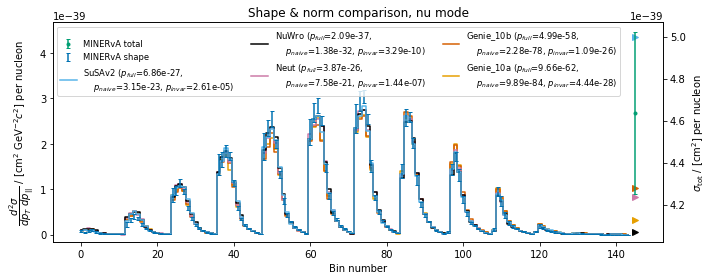

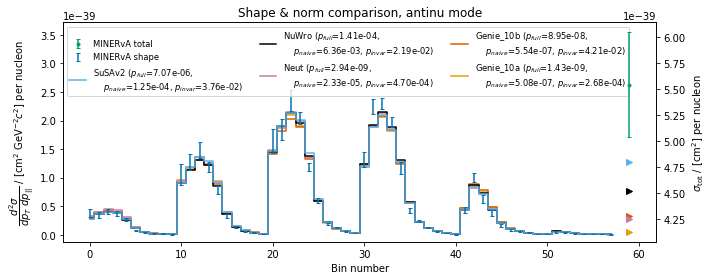

In [12]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.errorbar(
        np.arange(len(shape[mode])),
        shape[mode],
        np.sqrt(shape_var[mode]),
        linestyle="",
        label="MINERvA shape",
        zorder=4,
        capsize=2,
    )
    tot = ax2.errorbar(
        [len(shape[mode]) + 1],
        [data_integral[mode]],
        [total_error[mode]],
        linestyle="",
        marker=".",
        color="C6",
        label="MINERvA total",
        zorder=4,
        capsize=2,
    )
    for gen in files:
        y = MC_shape[(mode, gen)]
        art = ax.step(
            np.arange(len(y)),
            y,
            where="mid",
            label=gen
            + f" ($p_{{full}}$={p_all['Shape & norm.'][mode][gen]['full']:.2e},\n    "
            + f"$p_{{naive}}$={p_all['Shape & norm.'][mode][gen]['naive']:.2e}, "
            + f"$p_{{invar}}$={p_all['Shape & norm.'][mode][gen]['invariant']:.2e})",
        )
        ax2.plot(
            len(y) + 1,
            MC_integral[mode, gen],
            marker=">",
            linewidth=2,
            color=art[0].get_color(),
        )
    # ax.set_yscale("log")
    ax.set_ylim(top=ax.get_ylim()[1] * 1.4)
    ax.set_xlabel("Bin number")
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dp_{T}\ dp_{||}}$ / [cm$^2$ GeV$^{-2} c^{2}$] per nucleon"
    )
    ax2.set_ylabel(r"$\sigma_{\mathrm{tot}}$ / [cm$^2$] per nucleon")
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
        handles2[::-1] + handles[::-1],
        labels2[::-1] + labels[::-1],
        loc="upper left",
        ncol=3,
        fontsize="small",
        borderpad=0.3,
    )
    ax.set_title(f"Shape & norm comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-shape.pdf")

In [13]:
# Format p-values
gens = list(files.keys())
print(" & & & " + " & ".join(gens) + r" \\ \hline")
for mode in modes:
    _mode = mode
    for typ in ["Original", "Shape & norm.", "Shape only"]:
        _typ = typ
        for stat in ["full", "naive", "invariant"]:
            _stat = stat
            print(
                f"{_mode} & {_typ} & {_stat} & "
                + " & ".join(["%.2e" % (p_all[typ][mode][gen][stat],) for gen in gens])
                + r" \\"
            )
            _stat = ""
            _typ = ""
            _mode = ""

 & & & Genie_10a & Genie_10b & Neut & NuWro & SuSAv2 \\ \hline
nu & Original & full & 8.61e-41 & 1.02e-43 & 1.90e-17 & 7.82e-22 & 7.87e-37 \\
 &  & naive & 1.84e-47 & 1.87e-41 & 5.06e-08 & 3.24e-14 & 4.00e-18 \\
 &  & invariant & 1.53e-20 & 4.31e-21 & 1.72e-05 & 1.04e-06 & 1.94e-06 \\
 & Shape & norm. & full & 9.66e-62 & 4.99e-58 & 3.87e-26 & 2.09e-37 & 6.86e-27 \\
 &  & naive & 9.89e-84 & 2.28e-78 & 7.58e-21 & 1.38e-32 & 3.15e-23 \\
 &  & invariant & 4.44e-28 & 1.09e-26 & 1.44e-07 & 3.29e-10 & 2.61e-05 \\
 & Shape only & full & 9.37e-62 & 4.32e-58 & 3.11e-26 & 1.96e-37 & 7.36e-27 \\
 &  & naive & 8.78e-84 & 1.43e-78 & 6.60e-21 & 1.63e-32 & 2.54e-23 \\
 &  & invariant & 4.41e-28 & 1.08e-26 & 1.43e-07 & 3.27e-10 & 2.60e-05 \\
antinu & Original & full & 8.10e-03 & 1.49e-02 & 5.95e-03 & 9.45e-02 & 5.02e-03 \\
 &  & naive & 3.77e-12 & 3.56e-09 & 1.37e-08 & 3.70e-04 & 1.73e-01 \\
 &  & invariant & 2.47e-02 & 6.73e-02 & 5.31e-02 & 2.47e-01 & 4.79e-01 \\
 & Shape & norm. & full & 1.43e-09 & 8

In [41]:
%%time
# Test with toy data
N = 100000 * 4
rng = np.random.default_rng()
distances = {}

for mode in modes:
    # For inflated
    sigma_crit = 3
    p_crit = chi2.sf(sigma_crit**2, df=1)
    x_crit_worst = chi2.isf(p_crit, df=1) * len(data[mode])
    x_crit_prime = chi2.isf(p_crit, df=len(data[mode]))
    inflation = x_crit_worst / x_crit_prime
    print(inflation, np.sqrt(inflation))
    
    toys = rng.multivariate_normal(
        mean=np.zeros_like(data[mode]), cov=cov[mode], size=N
    )
    z = toys / np.sqrt(var[mode])
    distances[mode] = {
        r"invariant 3": (
            invariant3(z, alpha=2 / 3, fast=True),
            chi2(df=1),
        ),
        "naive": (naive(z), chi2(df=len(var[mode]))),
        "inflated": (inflated(z, alpha=inflation), chi2(df=len(var[mode]))),
        "full": (
            (toys[:, np.newaxis, :] @ cov_inv[mode] @ toys[:, :, np.newaxis]).flatten(),
            chi2(df=len(var[mode])),
        ),
    }
    del z
    del toys

6.621866302600459 2.573298720047958
5.645498142637008 2.3760257032778513
CPU times: user 30.8 s, sys: 18.8 s, total: 49.6 s
Wall time: 27.7 s


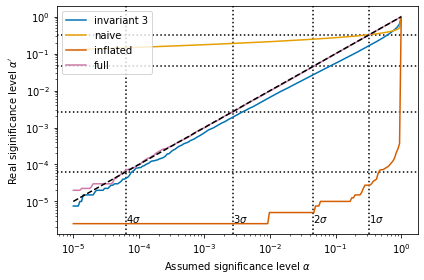

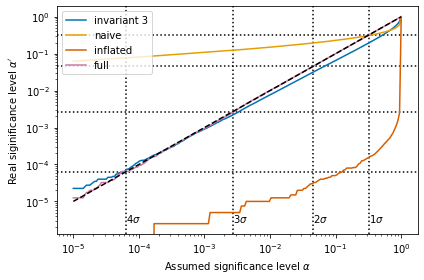

In [43]:
# siginifcance levels
for mode in modes:
    fig, ax = plt.subplots()
    for s in [1, 2, 3, 4]:
        SL = chi2.sf(s ** 2, df=1)
        ax.axhline(SL, color="k", linestyle="dotted")
        ax.axvline(SL, color="k", linestyle="dotted")
        ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

    x = np.logspace(-5, 0, 200)
    for name, (toys, expected) in distances[mode].items():
        y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
        ax.plot(x, y, label=name)
    ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Real siginificance level $\alpha'$")
    ax.set_xlabel(r"Assumed significance level $\alpha$")
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-significance.pdf")

In [36]:
del distances

In [17]:
%%time
# Test with shape + norm toy data
rng = np.random.default_rng()
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(
        mean=np.zeros(shape_total_cov[mode].shape[0]), cov=shape_total_cov[mode], size=N
    )
    z = toys / np.sqrt(np.diag(shape_total_cov[mode]))
    distances[mode] = {
        r"invariant 3": (
            invariant3(z, alpha=2 / 3, fast=True),
            chi2(df=1),
        ),
        "naive": (naive(z), chi2(df=z.shape[-1])),
        "full": (
            (
                toys[:, np.newaxis, :]
                @ shape_total_cov_inv[mode]
                @ toys[:, :, np.newaxis]
            ).flatten(),
            chi2(df=len(var[mode])),
        ),
    }
    del z
    del toys

CPU times: user 50.7 s, sys: 1min 18s, total: 2min 9s
Wall time: 44.8 s


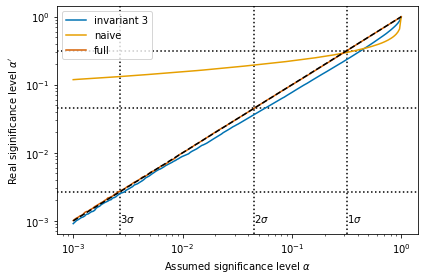

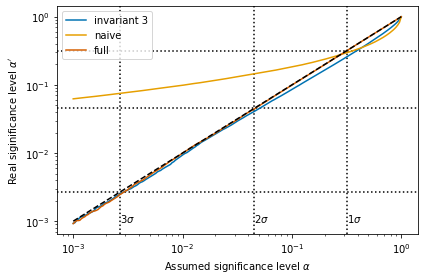

In [18]:
# siginifcance levels
for mode in modes:
    fig, ax = plt.subplots()
    for s in [1, 2, 3]:
        SL = chi2.sf(s ** 2, df=1)
        ax.axhline(SL, color="k", linestyle="dotted")
        ax.axvline(SL, color="k", linestyle="dotted")
        ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

    x = np.logspace(-3, 0, 200)
    for name, (toys, expected) in distances[mode].items():
        y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
        ax.plot(x, y, label=name)
    ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Real siginificance level $\alpha'$")
    ax.set_xlabel(r"Assumed significance level $\alpha$")
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-decomposed-significance.pdf")

In [19]:
del distances

NormaltestResult(statistic=6.322679063361742, pvalue=0.042368948502470506)
(100000, 144)
(100000,)
(100000, 144)
(100000, 145)
NormaltestResult(statistic=74.75906183913608, pvalue=5.838159898580985e-17)
(145, 145)
NormaltestResult(statistic=6.055182667522329, pvalue=0.04843215464079492)
(100000, 58)
(100000,)
(100000, 58)
(100000, 59)
NormaltestResult(statistic=37.198565181763115, pvalue=8.364388638094036e-09)
(59, 59)
CPU times: user 1min 18s, sys: 2min 25s, total: 3min 43s
Wall time: 1min 6s


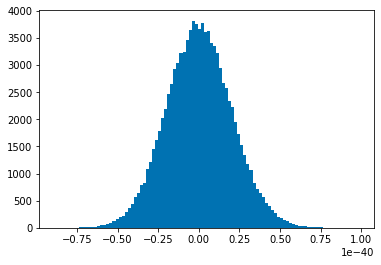

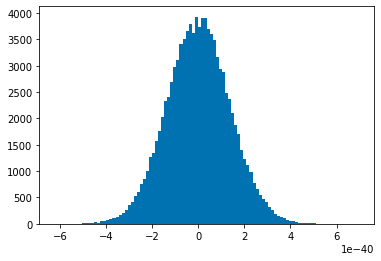

In [20]:
%%time
# Test with full toy data, but use shape + norm
rng = np.random.default_rng()
N = 100000
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(mean=data[mode], cov=cov[mode], size=N)
    print(normaltest(toys[:,30]))
    print(toys.shape)
    integrals = np.sum(toys * bin_widths[mode], axis=-1)
    print(integrals.shape)
    toys = toys / integrals[..., np.newaxis] * data_integral[mode]
    toys = toys - data[mode]
    if remove_bin:
        toys = toys[:, 1:]  # Ignore first bin
    print(toys.shape)
    toys = np.append(toys, (data_integral[mode] - integrals)[:, np.newaxis], axis=-1)
    print(toys.shape)
    print(normaltest(toys[:,30]))
    toy_cov = np.cov(toys.T)
    print(toy_cov.shape)
    toy_cov_inv = np.linalg.pinv(toy_cov)
    z = toys / np.sqrt(np.diag(shape_total_cov[mode]))
    distances[mode] = {
        r"invariant 3": (
            invariant3(z, alpha=2 / 3, fast=True),
            chi2(df=1),
        ),
        "naive": (naive(z), chi2(df=z.shape[-1])),
        "full": (
            (
                toys[:, np.newaxis, :]
                @ shape_total_cov_inv[mode]
                @ toys[:, :, np.newaxis]
            ).flatten(),
            chi2(df=len(var[mode])),
        ),
        "sample cov.": (
            (
                toys[:, np.newaxis, :]
                @ toy_cov_inv
                @ toys[:, :, np.newaxis]
            ).flatten(),
            chi2(df=len(var[mode])),
        ),
    }
    fig, ax = plt.subplots()
    ax.hist(toys[:,30], bins=100)
    del z
    del toys
    del integrals

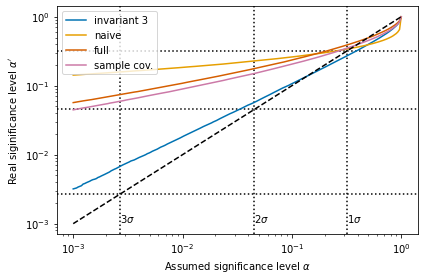

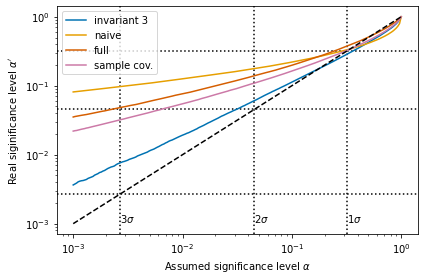

In [21]:
# siginifcance levels
for mode in modes:
    fig, ax = plt.subplots()
    for s in [1, 2, 3]:
        SL = chi2.sf(s ** 2, df=1)
        ax.axhline(SL, color="k", linestyle="dotted")
        ax.axvline(SL, color="k", linestyle="dotted")
        ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

    x = np.logspace(-3, 0, 200)
    for name, (toys, expected) in distances[mode].items():
        y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
        ax.plot(x, y, label=name)
    ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Real siginificance level $\alpha'$")
    ax.set_xlabel(r"Assumed significance level $\alpha$")
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-mixed-significance.pdf")

In [22]:
del distances

In [23]:
%%time
# Test power with toy data
N = 10000
rng = np.random.default_rng()
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(
        mean=np.zeros_like(data[mode]), cov=cov[mode], size=N
    )
    for gen in files:
        y = toys + MC[mode, gen] - MC[mode, gens[0]]
        z = y / np.sqrt(var[mode])
        distances[mode, gen] = {
            gen
            + " invariant 3": (
                invariant3(z, alpha=2 / 3, fast=True),
                chi2(df=1),
            ),
            gen + " naive": (naive(z), chi2(df=len(var[mode]))),
            gen
            + " full": (
                (y[:, np.newaxis, :] @ cov_inv[mode] @ y[:, :, np.newaxis]).flatten(),
                chi2(df=len(var[mode])),
            ),
        }
    del y
    del z
    del toys

CPU times: user 26.3 s, sys: 39.6 s, total: 1min 5s
Wall time: 22.7 s


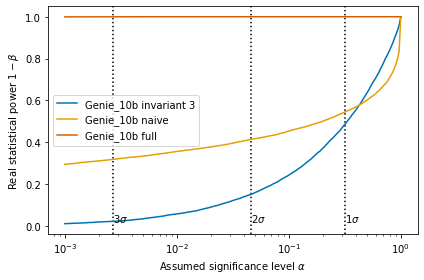

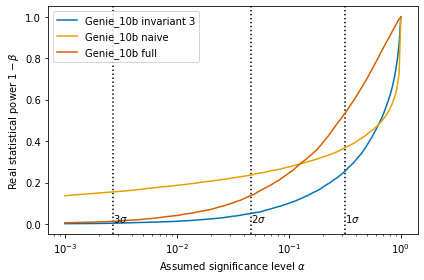

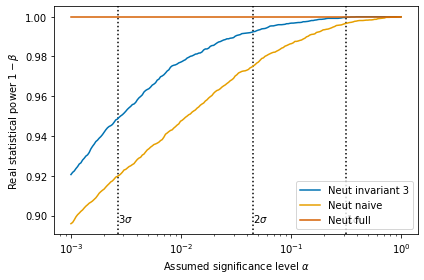

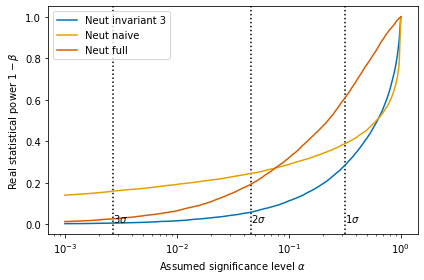

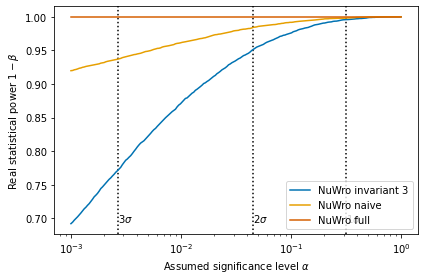

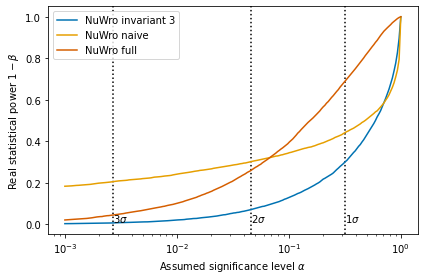

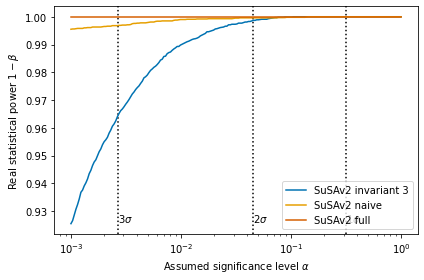

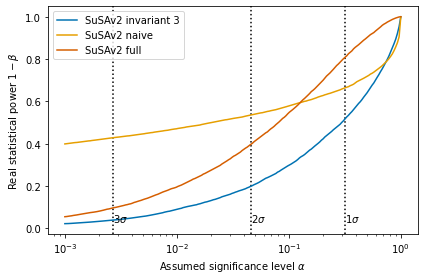

In [24]:
# power levels
gens = list(files.keys())
for gen in gens[1:]:
    for mode in modes:
        fig, ax = plt.subplots()
        for s in [1, 2, 3]:
            SL = chi2.sf(s ** 2, df=1)
            # ax.axhline(SL, color="k", linestyle="dotted")
            ax.axvline(SL, color="k", linestyle="dotted")
            ax.annotate(
                f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction")
            )

        x = np.logspace(-3, 0, 200)
        for name, (toys, expected) in distances[mode, gen].items():
            y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
            ax.plot(x, y, label=name)
        # ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
        # ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylabel(r"Real statistical power $1 - \beta$")
        ax.set_xlabel(r"Assumed significance level $\alpha$")
        ax.legend(loc="best")
        fig.tight_layout()
        fig.savefig(f"plots/minerva-{mode}-{gen}-power.pdf")

In [25]:
del distances

In [26]:
%%time
# Test power with decomposed toy data
N = 10000
rng = np.random.default_rng()
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(
        mean=np.zeros(shape_total_cov[mode].shape[0]), cov=shape_total_cov[mode], size=N
    )
    for gen in files:
        y = toys[..., :-1] + MC_shape[mode, gen] - MC_shape[mode, gens[0]]
        z = y / np.sqrt(shape_var[mode])
        z = np.append(
            z,
            (
                (toys[..., -1] + MC_integral[mode, gen] - MC_integral[mode, gens[0]])
                / total_error[mode]
            )[:, np.newaxis],
            axis=1,
        )
        distances[mode, gen] = {
            gen
            + " invariant 3": (
                invariant3(z, alpha=2 / 3, fast=True),
                chi2(df=1),
            ),
            gen + " naive": (naive(z), chi2(df=len(shape_var[mode]) + 1)),
            gen
            + " full": (
                (
                    y[:, np.newaxis, :] @ shape_cov_inv[mode] @ y[:, :, np.newaxis]
                ).flatten(),
                chi2(df=len(shape_var[mode]) + 1),
            ),
        }
    del y
    del z
    del toys

CPU times: user 28.6 s, sys: 45.2 s, total: 1min 13s
Wall time: 25.8 s


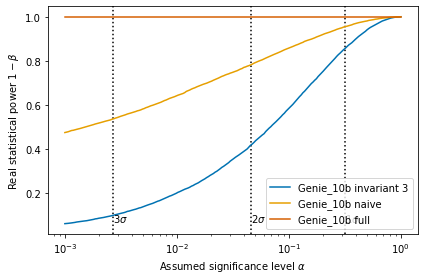

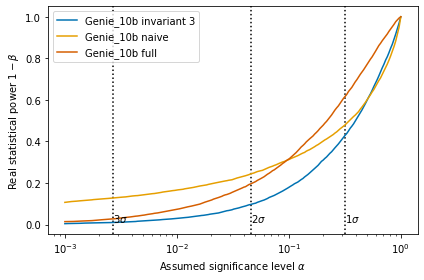

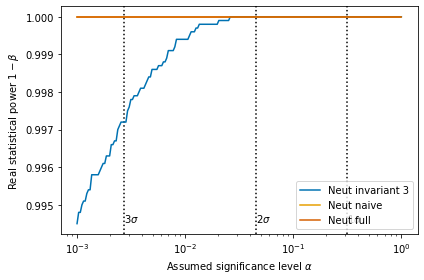

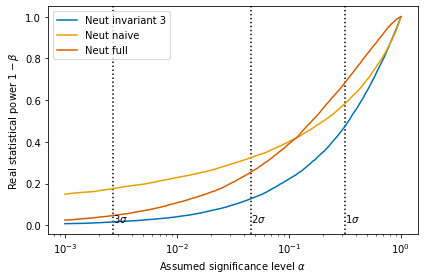

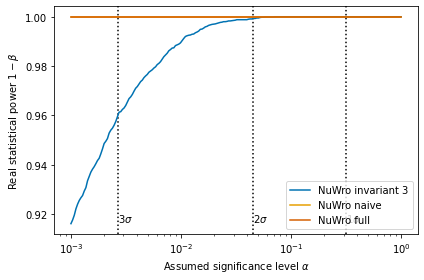

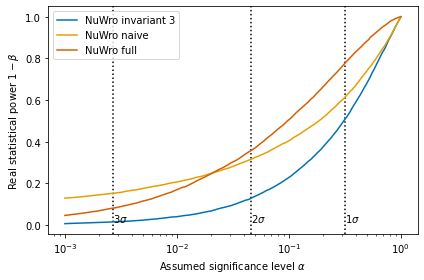

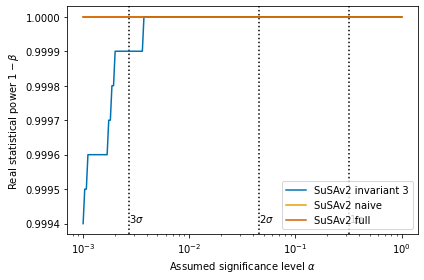

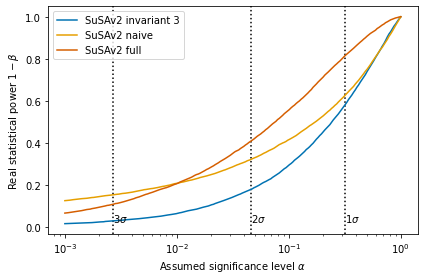

In [27]:
# power levels
gens = list(files.keys())
for gen in gens[1:]:
    for mode in modes:
        fig, ax = plt.subplots()
        for s in [1, 2, 3]:
            SL = chi2.sf(s ** 2, df=1)
            # ax.axhline(SL, color="k", linestyle="dotted")
            ax.axvline(SL, color="k", linestyle="dotted")
            ax.annotate(
                f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction")
            )

        x = np.logspace(-3, 0, 200)
        for name, (toys, expected) in distances[mode, gen].items():
            y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
            ax.plot(x, y, label=name)
        # ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
        # ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylabel(r"Real statistical power $1 - \beta$")
        ax.set_xlabel(r"Assumed significance level $\alpha$")
        ax.legend(loc="best")
        fig.tight_layout()
        fig.savefig(f"plots/minerva-{mode}-decomposed-{gen}-power.pdf")

In [28]:
del distances